In [1]:
import os
import pandas as pd
import numpy as np
from utils import its, plotline, plot_dual_indices

FP = '../data/cnn_2000_2021_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
#       .assign(cnnint=lambda df: np.where(df['program.name'].str.contains('international', case=False), 1,0))
#       .query('cnnint==1')
      .drop('timezone', axis=1) # always ET
      # Set date
      .assign(
          year=lambda df: np.where(df.year==3007, 2007,df.year),
          mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
      )
      # Drop outliers by length
      .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)}'))
      .pipe(lambda df: df.query(f'terms<{df.terms.quantile(q=0.99)}'))
      .groupby(['mthyr']).mean().reset_index()
     )
df.head(3)

,mthyr,year,month,date,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd
0,2000-01-01,2000.0,1.0,15.918734,45.506749,16.133773,17.220095,13.898100,1427.875462,445.313456,0.428103,91.932923,0.859707
1,2000-02-01,2000.0,2.0,14.941042,44.587922,16.324900,17.375724,14.010361,1332.407556,424.220378,0.433197,91.268712,0.859617
2,2000-03-01,2000.0,3.0,16.106129,44.570050,16.219880,17.247977,13.879870,1188.313901,390.624315,0.447117,89.244432,0.859692


In [3]:
xticklabels=range(2000, 2023, 3)

<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

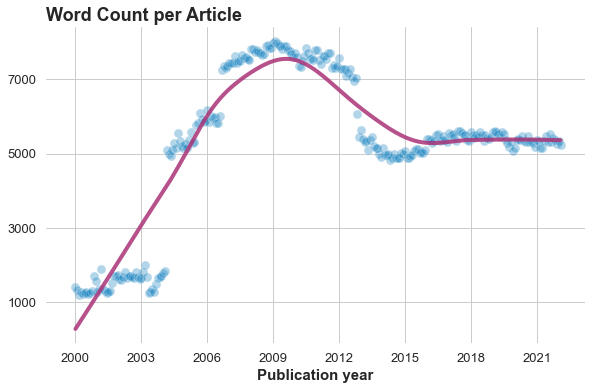

In [4]:
plotline(x=df.index, y=df.terms, xticklabels=xticklabels,
         yrange=range(1000,8000,2000), 
         title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'cnn_wordcount')
        )    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

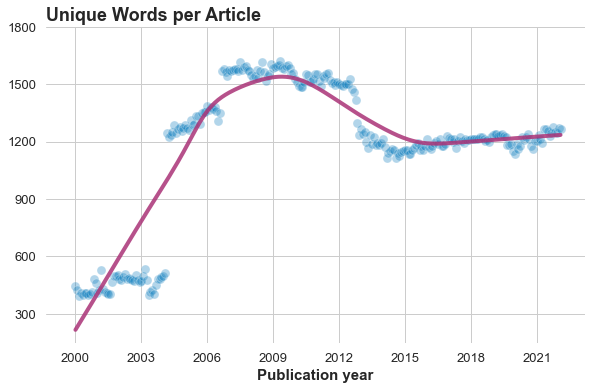

In [5]:
plotline(x=df.index, y=df.uniqueterms, xticklabels=xticklabels, 
         yrange=range(300,2000,300), 
         title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'cnn_uniquewords')
        ) 

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

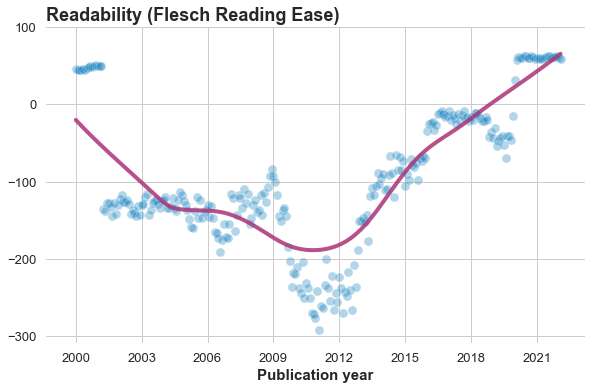

In [6]:
plotline(x=df.index, y=df.flesch_reading_ease, xticklabels=xticklabels, 
         yrange=range(-300,200,100), 
         title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'cnn_readability_flesch_ease')
        )    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

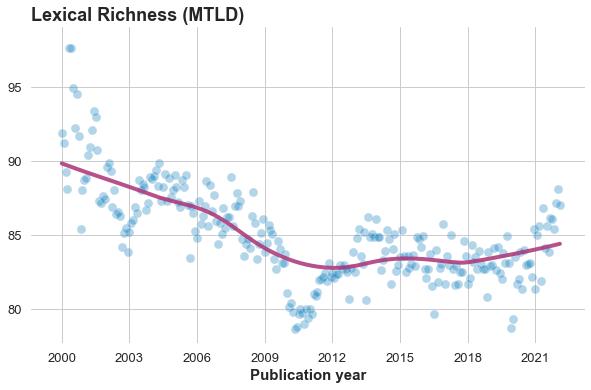

In [7]:
plotline(x=df.index, y=df.mtld, xticklabels=xticklabels, 
         yrange=range(80,100,5), 
         title='Lexical Richness (MTLD)', 
         savepath=os.path.join(SAVEPATH, 'cnn_lexicalrichness_mtld')
        )

In [8]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
      .drop('timezone', axis=1) # always ET
      .assign(
          year=lambda df: np.where(df.year==3007, 2007,df.year),
          mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
      )
      # Drop outliers by length
      .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)}'))
      .pipe(lambda df: df.query(f'terms<{df.terms.quantile(q=0.99)}'))       
      .groupby(['year']).mean().reset_index()
      .assign(
          iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
          ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
          imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
          ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
          iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
          iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
             )
     )
idf.head(3)

,year,month,date,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,2000.0,6.586884,15.703213,47.021933,15.615625,16.676750,13.670026,1339.879357,419.017870,0.430253,91.975510,0.861091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2001.0,6.790834,15.820201,-98.499860,68.747737,69.436423,18.669577,1456.341872,443.436978,0.411594,89.850614,0.860947,-309.476415,36.573083,-2.310284,-4.336643,8.692015,5.827701
2,2002.0,6.347693,15.735238,-131.507613,80.799261,81.306071,21.088244,1691.381662,483.575390,0.390133,86.897860,0.860382,-379.672919,54.266298,-5.520655,-9.324781,26.233877,15.406866


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change from 2000'>

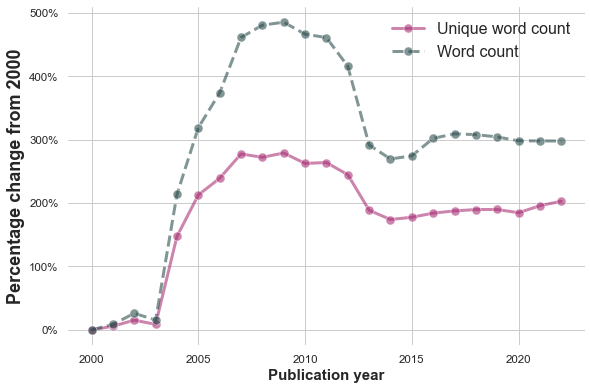

In [9]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, 
                  label1='Unique word count', label2='Word count', 
                  ylabel='Percentage change from 2000',
                  savepath=os.path.join(SAVEPATH, 'cnn_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change from 2000'>

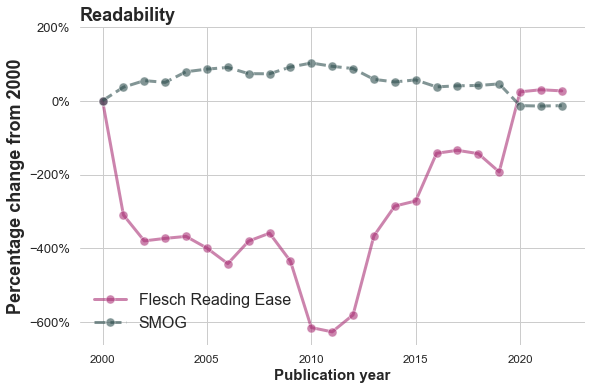

In [10]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog, 
                  yrange=range(-600,400,200), 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  ylabel='Percentage change from 2000',
                  savepath=os.path.join(SAVEPATH, 'cnn_readability_index')
                 )    

<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change from 2000'>

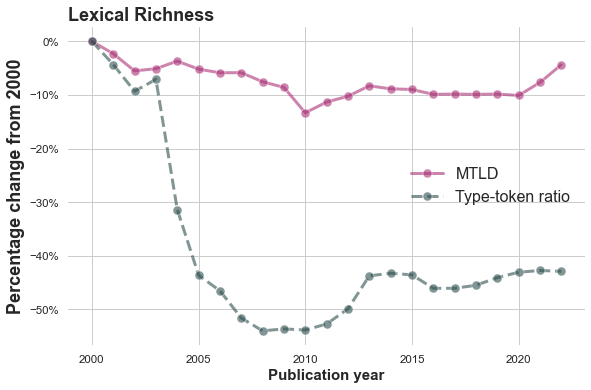

In [11]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  ylabel='Percentage change from 2000',
                  savepath=os.path.join(SAVEPATH, 'cnn_lexicalrichness_index')
                 )    